In [338]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

In [339]:
# --- 1. Load dữ liệu và chia tập Train/Test ---
df = pd.read_csv("diabetes.csv")
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Chia dữ liệu 
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [340]:
zeros_count = (df == 0).sum()
print(zeros_count[zeros_count > 0])
cols_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

Pregnancies      111
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
Outcome          500
dtype: int64


In [341]:
# Hàm model cố định
def get_model():
    return MLPClassifier(hidden_layer_sizes=(8,), max_iter=1000, random_state=42, learning_rate_init=0.01)

results = []
loss_curves = {}

In [342]:
# TRƯỜNG HỢP 1: NO PREPROCESSING
model_1 = get_model()
model_1.fit(X_train_raw, y_train)
acc_1 = accuracy_score(y_test, model_1.predict(X_test_raw))

# Lưu kết quả 
results.append({
    'Case': 'No Preprocessing', 
    'Accuracy': acc_1, 
    'Loss': model_1.loss_curve_[-1],
    'Iterations': model_1.n_iter_ 
})
loss_curves['No Preprocessing'] = model_1.loss_curve_

In [343]:
# TRƯỜNG HỢP 2: NORMALIZATION
pipe_2 = Pipeline([('scaler', MinMaxScaler()), ('model', get_model())])
pipe_2.fit(X_train_raw, y_train)
acc_2 = accuracy_score(y_test, pipe_2.predict(X_test_raw))

results.append({
    'Case': 'Normalization', 
    'Accuracy': acc_2, 
    'Loss': pipe_2['model'].loss_curve_[-1],
    'Iterations': pipe_2['model'].n_iter_ 
})
loss_curves['Normalization'] = pipe_2['model'].loss_curve_

In [344]:
# TRƯỜNG HỢP 3: STANDARDIZATION
pipe_3 = Pipeline([('scaler', StandardScaler()), ('model', get_model())])
pipe_3.fit(X_train_raw, y_train)
acc_3 = accuracy_score(y_test, pipe_3.predict(X_test_raw))

results.append({
    'Case': 'Standardization', 
    'Accuracy': acc_3, 
    'Loss': pipe_3['model'].loss_curve_[-1],
    'Iterations': pipe_3['model'].n_iter_ 
})
loss_curves['Standardization'] = pipe_3['model'].loss_curve_


In [345]:
# TRƯỜNG HỢP 4: OUTLIER REMOVAL
z_scores = np.abs((X_train_raw - X_train_raw.mean()) / X_train_raw.std())
mask_outlier = (z_scores < 3).all(axis=1)
X_train_clean = X_train_raw[mask_outlier]
y_train_clean = y_train[mask_outlier]

print(f"Đã loại bỏ {len(X_train_raw) - len(X_train_clean)} dòng outliers.")

model_4 = get_model()
model_4.fit(X_train_clean, y_train_clean)
acc_4 = accuracy_score(y_test, model_4.predict(X_test_raw))

results.append({
    'Case': 'Outlier Removal', 
    'Accuracy': acc_4, 
    'Loss': model_4.loss_curve_[-1],
    'Iterations': model_4.n_iter_ 
})
loss_curves['Outlier Removal'] = model_4.loss_curve_

Đã loại bỏ 65 dòng outliers.


In [346]:
# TRƯỜNG HỢP 5: MISSING-VALUE IMPUTATION
imputer_preprocessor = ColumnTransformer(
    transformers=[('imputer', SimpleImputer(missing_values=0, strategy='median'), cols_missing)],
    remainder='passthrough'
)
pipe_5 = Pipeline([('preprocessor', imputer_preprocessor), ('model', get_model())])
pipe_5.fit(X_train_raw, y_train)
acc_5 = accuracy_score(y_test, pipe_5.predict(X_test_raw))

results.append({
    'Case': 'Imputation', 
    'Accuracy': acc_5, 
    'Loss': pipe_5['model'].loss_curve_[-1],
    'Iterations': pipe_5['model'].n_iter_ 
})
loss_curves['Imputation'] = pipe_5['model'].loss_curve_


=== BẢNG SO SÁNH CHI TIẾT 5 TRƯỜNG HỢP ===
               Case Accuracy  Iterations     Loss
0  No Preprocessing   70.78%         111  0.58826
1     Normalization   78.57%         149  0.46817
2   Standardization   75.97%         174  0.41505
3   Outlier Removal   70.13%         204  0.55517
4        Imputation   73.38%         335  0.55911


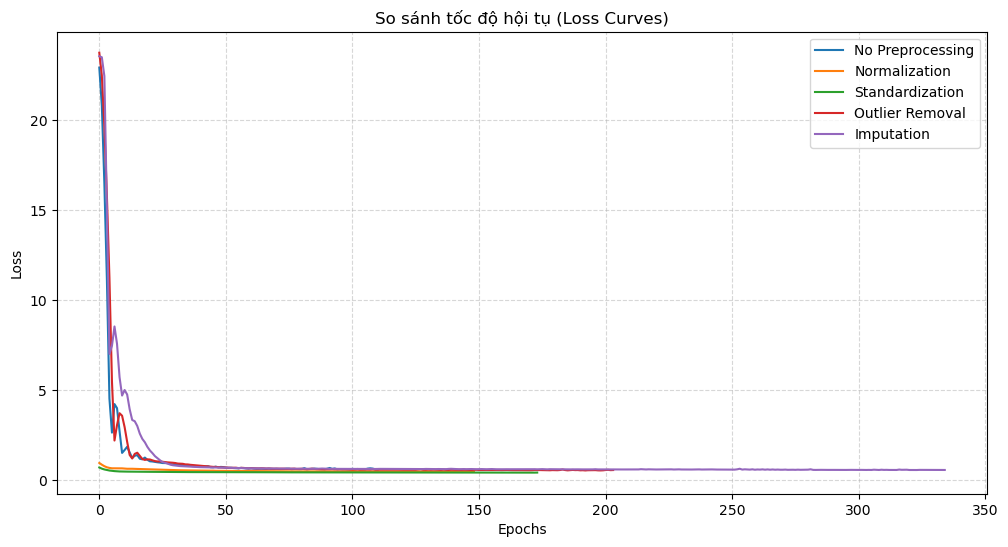

In [347]:
# HIỂN THỊ KẾT QUẢ
results_df = pd.DataFrame(results)

# Định dạng lại cho đẹp
results_df['Accuracy'] = results_df['Accuracy'].apply(lambda x: f"{x*100:.2f}%")
results_df['Loss'] = results_df['Loss'].apply(lambda x: f"{x:.5f}")

print("\n=== BẢNG SO SÁNH CHI TIẾT 5 TRƯỜNG HỢP ===")
# Sắp xếp lại cột cho dễ đọc
print(results_df[['Case', 'Accuracy', 'Iterations', 'Loss']])

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
for name, curve in loss_curves.items():
    plt.plot(curve, label=f"{name}")
plt.title('So sánh tốc độ hội tụ (Loss Curves)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()